In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

ROOT = "dataset processado"
RATINGS_ONLY_PATH = ROOT + '/ratings-only.csv'
MOVIES_ONLY_PATH = ROOT + '/movies-only.csv'

In [2]:
# Import the ratings dataset
df_ratings = pd.read_csv(ROOT + '/ratings-only.csv')

In [3]:
# Converting sklearn data into Pandas dataframe
# target variables imply
# 0.0 - Setosa
# 1.0 - Versicolor
# 2.0 - Virginica
df_ratings.head()

,userId,movieId,movieTitle,rating
0,15,1,Toy Story,2.0
1,15,2,Jumanji,2.0
2,15,5,Grumpier Old Men,4.5
3,15,6,Waiting to Exhale,4.0
4,15,10,Father of the Bride Part II,3.0


In [4]:
df_ratings.shape

(55141, 4)

In [5]:
# Number of movies
df_ratings['movieId'].nunique()

8291

In [6]:
# Number of users
df_ratings['userId'].nunique()

100

## Checking for outliers and imbalanced data

<AxesSubplot:xlabel='rating', ylabel='count'>

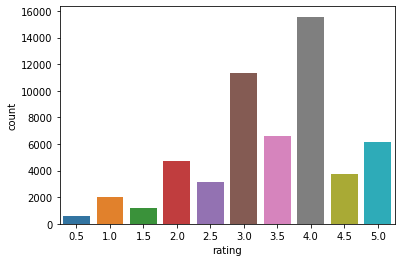

In [7]:
sns.countplot(x='rating', data=df_ratings)

## Separating features and target

In [8]:
movie_ratings_pivot=df_ratings.pivot(index="userId",columns="movieTitle",values="rating").fillna(0)
movie_ratings_pivot.head()

movieTitle,"'night, Mother",...All the Marbles,...And God Created Woman,...And Justice for All,...tick... tick... tick...,1-900,10,10 Rillington Place,10 Things I Hate About You,10 to Midnight,...,Zorba the Greek,"Zorro, The Gay Blade",Zus & Zo,eXistenZ,ivans xtc.,xXx,¡Three Amigos!,À Nous la Liberté,À la mode,’Round Midnight
userId,,,,,,,,,,,,,,,,,,,,,
15,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,1.5,0.0,0.0,3.5,0.0,0.0,0.0
30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0


In [9]:
from scipy.sparse import csr_matrix

# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(movie_ratings_pivot.values)
mat_movie_features

<100x8291 sparse matrix of type '<class 'numpy.float64'>'
	with 55141 stored elements in Compressed Sparse Row format>

# Configure KNN model

In [10]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [11]:
model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

# Escolhendo usuário aleatório e listando os filmes que maior avaliação

In [12]:
user_index = 232
user_favorite_movies = df_ratings[df_ratings['userId'] == user_index].sort_values('rating', ascending=False)
user_favorite_movies.head()

,userId,movieId,movieTitle,rating
16323,232,1939,Cyborg,5.0
16214,232,1245,All Dogs Go to Heaven,5.0
16212,232,1243,Shallow Grave,5.0
16211,232,1242,Rocky V,5.0
16208,232,1237,Needful Things,5.0


In [74]:
movie_ratings_pivot.loc[user_index]

movieTitle
'night, Mother                0.0
...All the Marbles            0.0
...And God Created Woman      0.0
...And Justice for All        0.0
...tick... tick... tick...    0.0
                             ... 
xXx                           0.0
¡Three Amigos!                2.0
À Nous la Liberté             0.0
À la mode                     4.0
’Round Midnight               0.0
Name: 232, Length: 8291, dtype: float64

# Recomendando filme

In [134]:
def recommend(user_id):
    distances, indices = model_knn.kneighbors(
                movie_ratings_pivot.loc[user_id].values.reshape(1,-1),
                n_neighbors=2)

    user_ratings = movie_ratings_pivot.loc[user_id]

    closest_user_id = movie_ratings_pivot.index[indices.flatten()[1]]
    closest_user_ratings = movie_ratings_pivot.loc[closest_user_id]
    
    r = movie_ratings_pivot.loc[closest_user_id][(closest_user_ratings > 0) & (user_ratings == 0)]
    r = r.sort_values(ascending=False)

    return r

In [176]:
recommendations = recommend(user_index)
recommendations.head(10)

movieTitle
Indiana Jones and the Temple of Doom    5.0
Roman Holiday                           5.0
Black Knight                            5.0
Outrageous Fortune                      5.0
Outbreak                                5.0
The Shop on Main Street                 5.0
The Town Is Quiet                       5.0
Nina Takes a Lover                      5.0
Mulholland Falls                        5.0
Casablanca                              5.0
Name: 119, dtype: float64

In [170]:
df_movies = pd.read_csv(MOVIES_ONLY_PATH)
df_movies.head()

,currentId,title,overview,genres,runtime,releaseDate,posterPath
0,1,Toy Story,"Led by Woody, Andy's toys live happily in his ...","Animation, Comedy, Family",81.0,1995-10-30,https://flixpatrol.com/runtime/cache/files/pos...
1,2,Jumanji,When siblings Judy and Peter discover an encha...,"Adventure, Fantasy, Family",104.0,1995-12-15,https://flixpatrol.com/runtime/cache/files/pos...
2,5,Grumpier Old Men,A family wedding reignites the ancient feud be...,"Romance, Comedy",101.0,1995-12-22,https://flixpatrol.com/runtime/cache/files/pos...
3,6,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","Comedy, Drama, Romance",127.0,1995-12-22,https://flixpatrol.com/runtime/cache/files/pos...
4,10,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,106.0,1995-02-10,https://flixpatrol.com/runtime/cache/files/pos...


In [190]:
def get_formatted_recommendations(recommendations):
  df_movies = pd.read_csv(MOVIES_ONLY_PATH)
  df_movie_ratings = df_movies[df_movies['title'].isin(recommendations.index)]
  df_movie_ratings = df_movie_ratings.set_index("title")
  df_movie_ratings.insert(2, 'rating', recommendations)
  df_movie_ratings = df_movie_ratings.sort_values(by=['rating'], ascending=False)
  return df_movie_ratings.reset_index()
  
df_formatted_recommendations = get_formatted_recommendations(recommendations)
df_formatted_recommendations

,title,currentId,overview,rating,genres,runtime,releaseDate,posterPath
0,Some Like It Hot,3897,Two musicians witness a mob hit and struggle t...,5.0,"Comedy, Romance",122.0,1959-03-18,https://flixpatrol.com/runtime/cache/files/pos...
1,Something to Talk About,745,"In one of her best-ever roles, Julia Roberts i...",5.0,Comedy,106.0,1995-08-04,https://flixpatrol.com/runtime/cache/files/pos...
2,The Town Is Quiet,3414,A dark tale of working-class life in Marseille...,5.0,"Drama, Foreign",133.0,2000-08-30,https://flixpatrol.com/runtime/cache/files/pos...
3,War Stories Our Mother Never Told Us,3052,Seven New Zealand women speak about their live...,5.0,"Action, Adventure, Crime, Mystery, Thriller",95.0,1995-10-27,https://flixpatrol.com/runtime/cache/files/pos...
4,Fled,3429,"During a routine prison work detail, convict P...",5.0,"Action, Comedy, Thriller",98.0,1996-07-19,https://flixpatrol.com/runtime/cache/files/pos...
...,...,...,...,...,...,...,...,...
330,"Monsters, Inc.",3490,"James Sullivan and Mike Wazowski are monsters,...",1.0,"Animation, Comedy, Family",92.0,2001-11-01,https://flixpatrol.com/runtime/cache/files/pos...
331,Federal Hill,1556,"In Providence's Italian neighborhood, Federal ...",1.0,"Action, Adventure, Crime, Mystery, Thriller",97.0,1995-02-24,https://flixpatrol.com/runtime/cache/files/pos...
332,Cold Fever,2710,A Japanese businessman travels to Iceland and ...,1.0,"Drama, Comedy",85.0,1995-02-10,https://flixpatrol.com/runtime/cache/files/pos...
333,I Never Promised You a Rose Garden,611,"A disturbed,institutionalized 16-year-old girl...",1.0,Drama,96.0,1977-07-14,https://flixpatrol.com/runtime/cache/files/pos...
